In [10]:
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
from langsmith import Client
client = Client()
prompt = client.pull_prompt("hwchase17/react", include_model=True)

prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}')

In [12]:
from langchain_core.tools import tool
from langchain_community.tools import TavilySearchResults

@tool
def triple(num: float) -> float:
    """
    param num: a number to triple
    return: 3 multiplied by number
    """
    
    return 3 * num

tavily_search_tool = TavilySearchResults(max_results=5)

tools = [tavily_search_tool, triple]

In [13]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

react_agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)
react_agent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermediate_steps']))
})
| PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': 'tavily_search_results_json - A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.\ntriple(num: float) -> float - param num: a number to triple\nreturn: 3 multiplied by number', 'tool_names': 'tavily_search_results_json, triple'}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, sho

In [7]:
temp_agent_action = react_agent.invoke({
    "input": "tell me about elon musk in 1 bullet point",
    "intermediate_steps": []
})
temp_agent_action

AgentAction(tool='tavily_search_results_json', tool_input='Elon Musk summary', log='I should provide a concise summary of Elon Musk in a single bullet point that captures his significance. However, since he\'s a well-known figure with a wide range of accomplishments and details, it might be useful to search for a summarized version. \n\nAction: tavily_search_results_json  \nAction Input: "Elon Musk summary"  ')

In [8]:
tool_name = temp_agent_action.tool
tool_input = temp_agent_action.tool_input

tool_function = None
for tool in tools:
    if tool.name == tool_name:
        tool_function = tool


if tool_function:
    if isinstance(tool_input, dict):
        output = tool_function.invoke(**tool_input)
    else:
        output = tool_function.invoke(tool_input)
        
output

[{'title': "Elon Musk's Biography Summary - Dante",
  'url': 'https://dantekim.com/notes/elon-musk-tesla-spacex-and-the-quest-for-a-fantastic-future/',
  'content': 'The book first talks about Elon\'s life growing up and his early educational career. Vance throws in Elon\'s romantic relationships in places where it is appropriate.\n Musk was bullied during his childhood and also had an extremely difficult relationship with his father, so much so that he did not want to talk about it. Musk says, however, that he is thankful for those difficult times because it shaped him into the man he is today. [...] During college Elon wrote an extremely detailed and long final paper explaining the inner workings of solar power and how it is becoming a very viable market due to rapid technological improvements. [...] "instead of doing the fashionable Silicon Valley thing of "pivoting" toward a new idea or plan, Musk would dig in deeper."\n\n"If you put a number on the projector that does not make sen

In [9]:
str(output)

'[{\'title\': "Elon Musk\'s Biography Summary - Dante", \'url\': \'https://dantekim.com/notes/elon-musk-tesla-spacex-and-the-quest-for-a-fantastic-future/\', \'content\': \'The book first talks about Elon\\\'s life growing up and his early educational career. Vance throws in Elon\\\'s romantic relationships in places where it is appropriate.\\n Musk was bullied during his childhood and also had an extremely difficult relationship with his father, so much so that he did not want to talk about it. Musk says, however, that he is thankful for those difficult times because it shaped him into the man he is today. [...] During college Elon wrote an extremely detailed and long final paper explaining the inner workings of solar power and how it is becoming a very viable market due to rapid technological improvements. [...] "instead of doing the fashionable Silicon Valley thing of "pivoting" toward a new idea or plan, Musk would dig in deeper."\\n\\n"If you put a number on the projector that doe

In [ ]:
# from langgraph.prebuilt import ToolNode

# tool_node = ToolNode(tools=tools)
# print(temp_agent_action.tool_input)
# response = tool_node.invoke(temp_agent_action.tool_input)
# response

In [14]:
from typing import TypedDict, Union, Annotated
from langchain.schema import AgentAction, AgentFinish
from operator import add

class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], add]

In [15]:
from langgraph.prebuilt import ToolNode

def run_agent_reasoning_engine(state):
    input = state["input"]
    agent_outcome = react_agent.invoke({
                        "input": input,
                        "intermediate_steps": state["intermediate_steps"]
                    })
    
    return {"agent_outcome": agent_outcome}


def execute_tools(state):
    tool_node = ToolNode(tools=tools)
    agent_action = state["agent_outcome"]
    
    tool_name = agent_action.tool
    tool_input = agent_action.tool_input
    
    tool_function = None
    for tool in tools:
        if tool.name == tool_name:
            tool_function = tool
    
    if tool_function:
        if isinstance(tool_input, dict):
            response = tool_function.invoke(**tool_input)
        else:
            response = tool_function.invoke(tool_input)
    
    return {"intermediate_steps": [(agent_action, str(response))]}


def should_continue(state):
    agent_action = state["agent_outcome"]
    if isinstance(agent_action, AgentFinish):
        return "end"
    else:
        return "act"
    
    

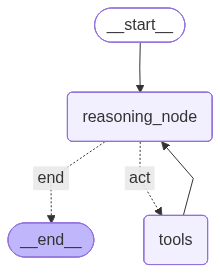

In [16]:
from langgraph.graph import StateGraph, END
from IPython.display import Image

flow = StateGraph(state_schema=AgentState)
flow.add_node("reasoning_node", run_agent_reasoning_engine)
flow.add_node("tools", execute_tools)

flow.add_conditional_edges("reasoning_node", should_continue, {
    "act": "tools",
    "end": END
})

flow.add_edge("tools", "reasoning_node")

flow.set_entry_point("reasoning_node")
app = flow.compile()
Image(app.get_graph().draw_mermaid_png())

In [17]:
app.invoke({
    "input": "tell me about elon musk in 1 bullet point"
})

{'input': 'tell me about elon musk in 1 bullet point',
 'agent_outcome': AgentFinish(return_values={'output': 'Elon Musk is the CEO of Tesla and SpaceX, known for his controversial public persona and significant impact on technology and business, particularly in 2023 where he faced substantial challenges, including financial losses and criticism regarding his influence over social media and the stock market.'}, log='I now have enough information to summarize Elon Musk in a concise manner. Based on the gathered data, I will create a bullet point that captures the essence of what is currently known about him.  \n\nFinal Answer: Elon Musk is the CEO of Tesla and SpaceX, known for his controversial public persona and significant impact on technology and business, particularly in 2023 where he faced substantial challenges, including financial losses and criticism regarding his influence over social media and the stock market.'),
 'intermediate_steps': [(AgentAction(tool='tavily_search_resul